# ベイズ回帰モデルによる効果検証

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import random

random.seed(42)

In [3]:
# Data
df = pd.read_csv(pm.get_data('test_scores.csv'), index_col=0)
df

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
220,68,0,2.0,2.0,False,0.0,53,0.0,1.0,True,False
221,104,1,2.0,0.0,False,0.0,52,1.0,1.0,False,False
222,71,1,1.0,NaN,False,0.0,57,1.0,NaN,False,True
223,118,0,2.0,0.0,False,0.0,57,1.0,NaN,True,False


欠損値が３項目あり。  
※欠損値のある行は全部落とす、とする。

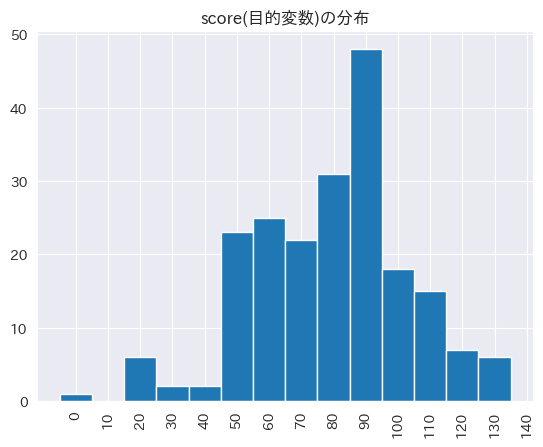

In [4]:
# score（目的変数）の分布
bins = np.arange(0, 150, 10)
fig, ax = plt.subplots()
df['score'].hist(bins=bins, align='left')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('score(目的変数)の分布')
plt.xticks(bins)
plt.show()

おおよそ 100 程度の、正の値をとることがわかった。

In [5]:
# 統計情報
df.describe()

,score,male,siblings,family_inv,prev_disab,age_test,non_severe_hl,mother_hs
count,207.000000,207.000000,207.000000,174.000000,189.000000,207.000000,207.000000,134.000000
mean,84.193237,0.512077,1.125604,0.977011,0.238095,53.545894,0.415459,0.701493
std,24.885590,0.501066,0.866682,1.002621,0.427049,3.631920,0.493996,0.459320
min,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000
25%,68.000000,0.000000,1.000000,0.000000,0.000000,50.000000,0.000000,0.000000
50%,87.000000,1.000000,1.000000,1.000000,0.000000,54.000000,0.000000,1.000000
75%,98.000000,1.000000,2.000000,2.000000,0.000000,57.000000,1.000000,1.000000
max,144.000000,1.000000,3.000000,4.000000,1.000000,59.000000,1.000000,1.000000


In [6]:
# 欠損値除去
df_proc = df.dropna().astype(float)  # 線形回帰の予測計算はすべて浮動小数点型で行われるため型変更も合わせて実施
df_proc

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,39.0,0.0,2.0,3.0,1.0,1.0,50.0,1.0,1.0,0.0,1.0
12,109.0,1.0,1.0,0.0,0.0,0.0,48.0,1.0,1.0,1.0,0.0
14,91.0,0.0,2.0,0.0,0.0,0.0,58.0,1.0,1.0,1.0,1.0
19,65.0,1.0,0.0,2.0,0.0,0.0,50.0,1.0,1.0,0.0,1.0
21,71.0,1.0,1.0,2.0,0.0,1.0,58.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
212,58.0,0.0,1.0,1.0,0.0,0.0,58.0,0.0,0.0,0.0,1.0
216,133.0,0.0,1.0,0.0,0.0,0.0,59.0,1.0,1.0,0.0,0.0
218,92.0,1.0,2.0,1.0,1.0,0.0,52.0,1.0,1.0,0.0,1.0
220,68.0,0.0,2.0,2.0,0.0,0.0,53.0,0.0,1.0,1.0,0.0


In [7]:
# 目的変数と説明変数へ分離
y_score    = df_proc.pop('score')
X_features = df_proc.copy()

X_features

,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,0.0,2.0,3.0,1.0,1.0,50.0,1.0,1.0,0.0,1.0
12,1.0,1.0,0.0,0.0,0.0,48.0,1.0,1.0,1.0,0.0
14,0.0,2.0,0.0,0.0,0.0,58.0,1.0,1.0,1.0,1.0
19,1.0,0.0,2.0,0.0,0.0,50.0,1.0,1.0,0.0,1.0
21,1.0,1.0,2.0,0.0,1.0,58.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
212,0.0,1.0,1.0,0.0,0.0,58.0,0.0,0.0,0.0,1.0
216,0.0,1.0,0.0,0.0,0.0,59.0,1.0,1.0,0.0,0.0
218,1.0,2.0,1.0,1.0,0.0,52.0,1.0,1.0,0.0,1.0
220,0.0,2.0,2.0,0.0,0.0,53.0,0.0,1.0,1.0,0.0


In [8]:
# 標準化
X_features -= X_features.mean()
X_features /= X_features.std()

X_features

,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,-1.004938,1.078165,2.227502,2.480475,1.782293,-0.978004,1.179344,0.616250,-0.772789,1.132532
12,0.985234,-0.080289,-0.911722,-0.399157,-0.555520,-1.562492,1.179344,0.616250,1.281203,-0.874235
14,-1.004938,1.078165,-0.911722,-0.399157,-0.555520,1.359947,1.179344,0.616250,1.281203,1.132532
19,0.985234,-1.238742,1.181094,-0.399157,-0.555520,-0.978004,1.179344,0.616250,-0.772789,1.132532
21,0.985234,-0.080289,1.181094,-0.399157,1.782293,1.359947,-0.839533,-1.606652,1.281203,1.132532
...,...,...,...,...,...,...,...,...,...,...
212,-1.004938,-0.080289,0.134686,-0.399157,-0.555520,1.359947,-0.839533,-1.606652,-0.772789,1.132532
216,-1.004938,-0.080289,-0.911722,-0.399157,-0.555520,1.652191,1.179344,0.616250,-0.772789,-0.874235
218,0.985234,1.078165,0.134686,2.480475,-0.555520,-0.393517,1.179344,0.616250,-0.772789,1.132532
220,-1.004938,1.078165,1.181094,-0.399157,-0.555520,-0.101273,-0.839533,0.616250,1.281203,-0.874235


In [9]:
# 変数定義
N, D = X_features.shape  # N: データ件数, D: データ項目数

columns = X_features.columns.values  # 項目名一覧

print(N, D, columns)

101 10 ['male' 'siblings' 'family_inv' 'non_english' 'prev_disab' 'age_test'
 'non_severe_hl' 'mother_hs' 'early_ident' 'non_white']


線形重回帰モデルとなるため、１次関数の式は

$y_n = \mathbf{\alpha} \cdot \mathbf{x^T_n} + \beta * \epsilon_n$

と $\mathbf{\alpha}$ と $\mathbf{x^T_n}$ のベクトル同士の内積になる。

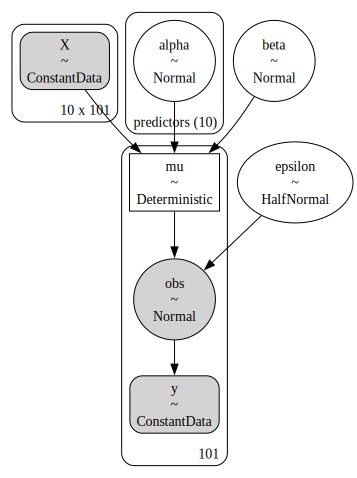

In [14]:
# 確率モデル定義
model_lsl_dr = pm.Model(coords={'predictors': columns})  # コンテキスト内で predictors（項目名のリスト）を扱えるようにする

with model_lsl_dr:
    X = pm.ConstantData('X', X_features.T)  # 従来のベクトルが行列になるため、内積計算のため転置する
    y = pm.ConstantData('y', y_score)  # 目的変数

    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0, dims='predictors')  # 項目インデックスと対応づくように定義
    beta = pm.Normal('beta', mu=100.0, sigma=25.0)  # 目的変数（y_score）の観測値が事前の統計情報から 100 程度と分かっているため、mu=100, 合わせてsigma を調整している
    epsilon = pm.HalfNormal('epsilon', sigma=25.0)

    mu = pm.Deterministic('mu', alpha @ X + beta)

    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=y)

# 定義した確率モデルを可視化
pm.model_to_graphviz(model_lsl_dr)

In [15]:
# Sampling
with model_lsl_dr:
    inference_lsl_dr = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.


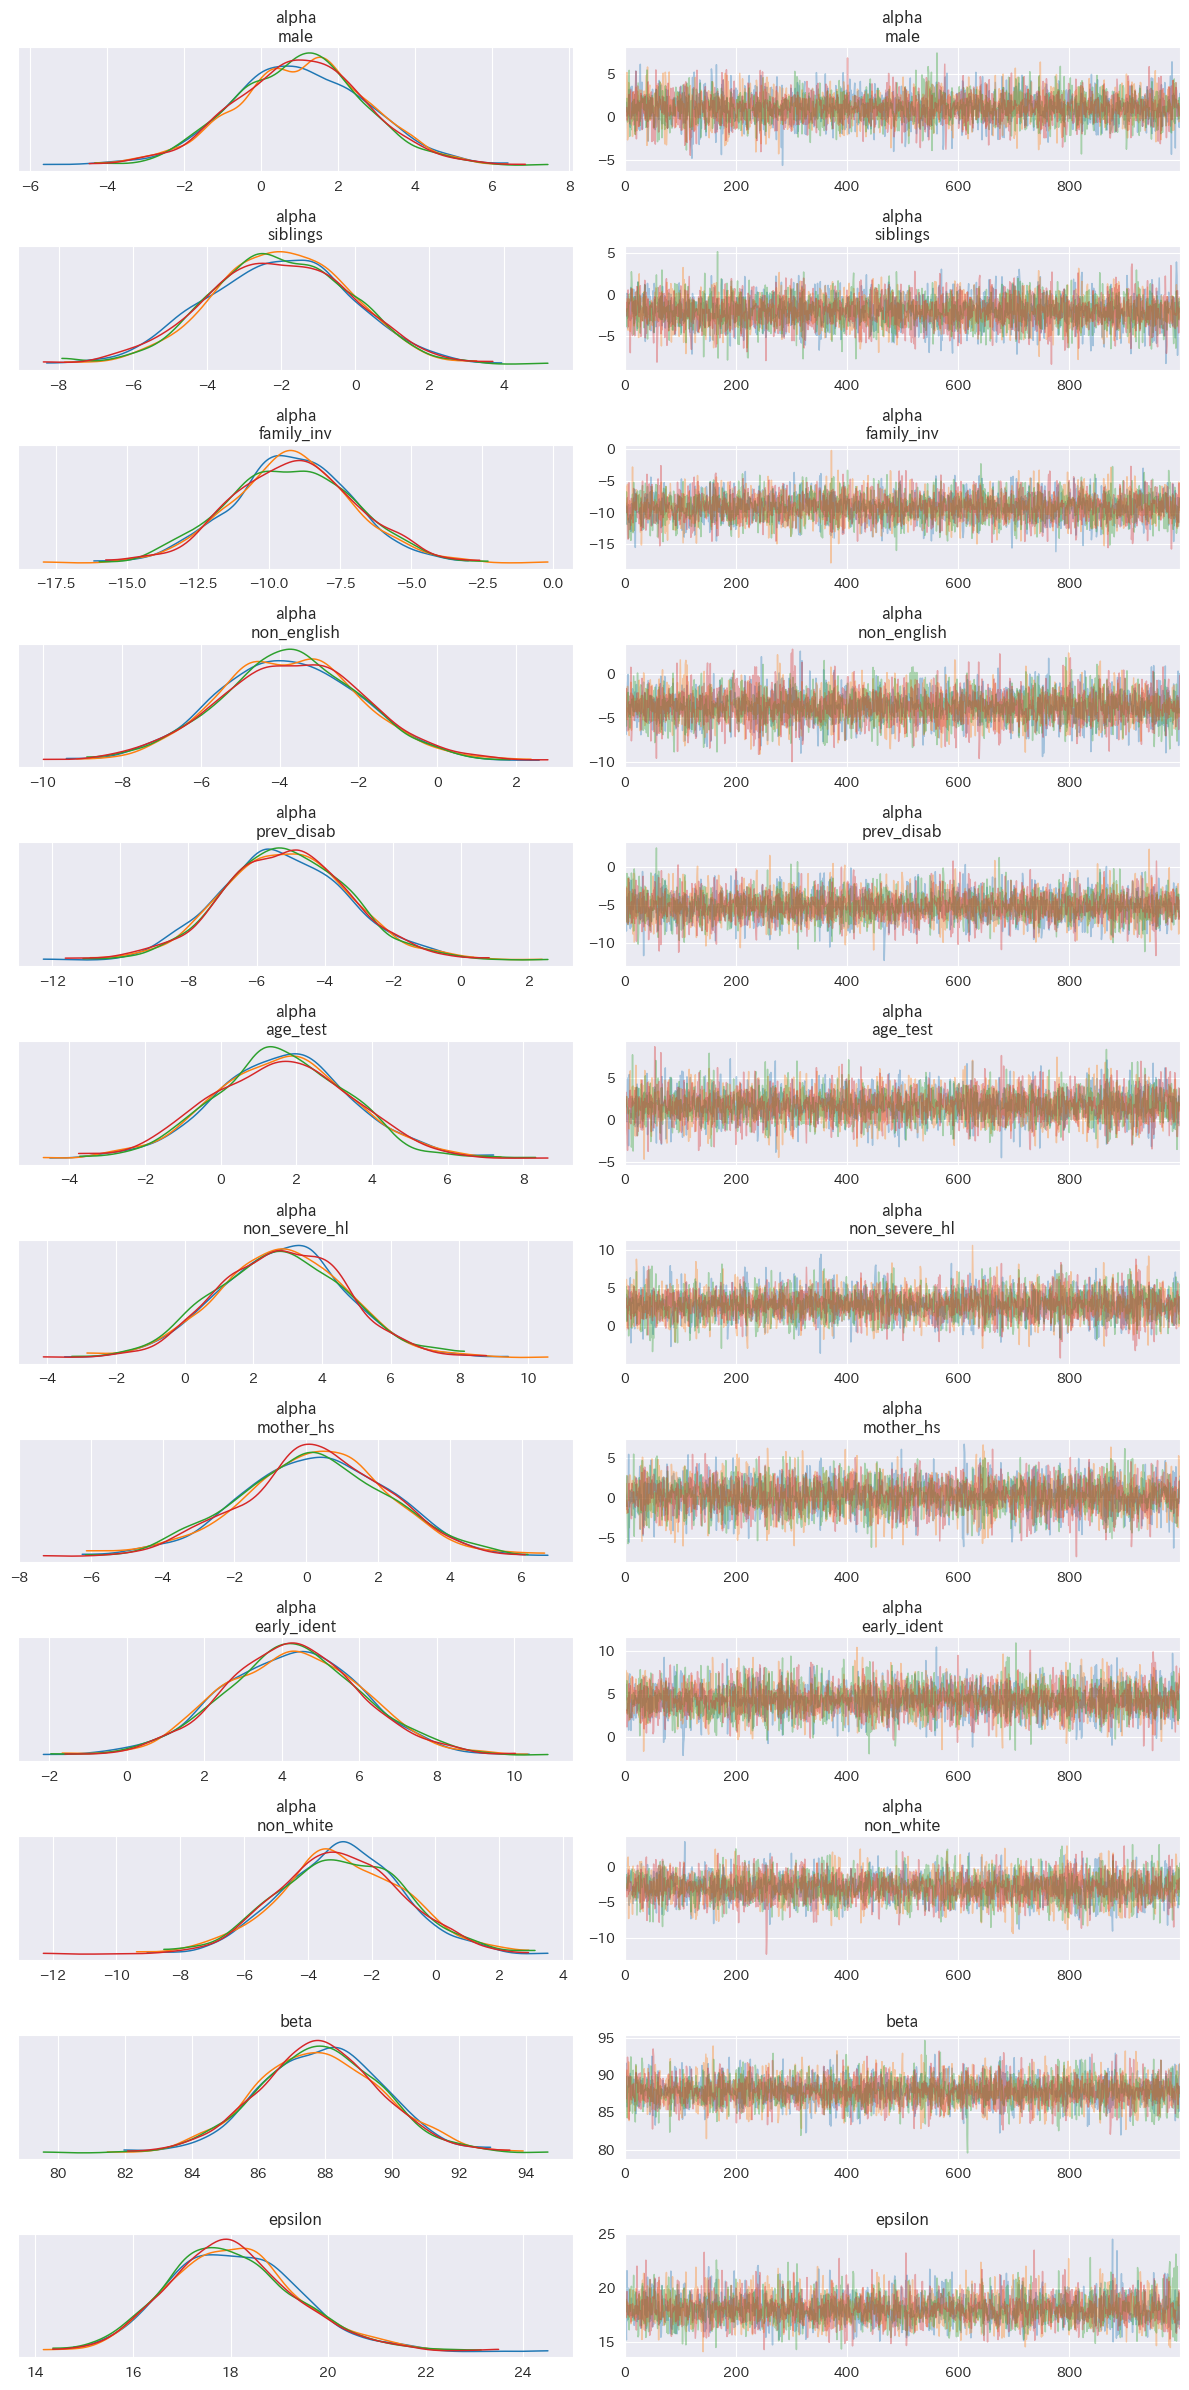

In [16]:
# 収束状況
az.plot_trace(inference_lsl_dr, var_names=['alpha', 'beta', 'epsilon'], compact=False)
plt.tight_layout()
plt.show()

各確率変数の 
- グラフがほぼ同じ形状
- 値が均等にばらついている

うまく収束されている様子。

>各説明変数に項目名      
>確率モデルのインスタンス生成時に `coords={'predictors': columns}` を指定した効果

In [18]:
# alpha の統計情報
summary_lsl_dr_alpha = az.summary(inference_lsl_dr, var_names=['alpha'])
summary_lsl_dr_alpha

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[male],1.012,1.715,-2.165,4.262,0.021,0.025,6393.0,3299.0,1.0
alpha[siblings],-2.043,1.872,-5.457,1.457,0.023,0.021,6428.0,3569.0,1.0
alpha[family_inv],-9.199,2.151,-13.141,-5.066,0.029,0.021,5463.0,2996.0,1.0
alpha[non_english],-3.736,1.848,-7.362,-0.381,0.023,0.017,6638.0,2703.0,1.0
alpha[prev_disab],-5.143,1.871,-8.862,-1.757,0.023,0.017,6788.0,3349.0,1.0
alpha[age_test],1.631,1.844,-1.585,5.355,0.022,0.020,6761.0,3469.0,1.0
alpha[non_severe_hl],2.832,1.872,-0.693,6.234,0.023,0.020,6803.0,2636.0,1.0
alpha[mother_hs],0.245,2.046,-3.736,3.968,0.026,0.035,6387.0,2652.0,1.0
alpha[early_ident],4.256,1.775,1.057,7.682,0.023,0.017,5893.0,2825.0,1.0
alpha[non_white],-2.941,1.949,-6.502,0.814,0.026,0.022,5515.0,3005.0,1.0


array([[<Axes: title={'center': 'alpha\nmale'}>,
        <Axes: title={'center': 'alpha\nsiblings'}>,
        <Axes: title={'center': 'alpha\nfamily_inv'}>],
       [<Axes: title={'center': 'alpha\nnon_english'}>,
        <Axes: title={'center': 'alpha\nprev_disab'}>,
        <Axes: title={'center': 'alpha\nage_test'}>],
       [<Axes: title={'center': 'alpha\nnon_severe_hl'}>,
        <Axes: title={'center': 'alpha\nmother_hs'}>,
        <Axes: title={'center': 'alpha\nearly_ident'}>],
       [<Axes: title={'center': 'alpha\nnon_white'}>, <Axes: >, <Axes: >]],
      dtype=object)

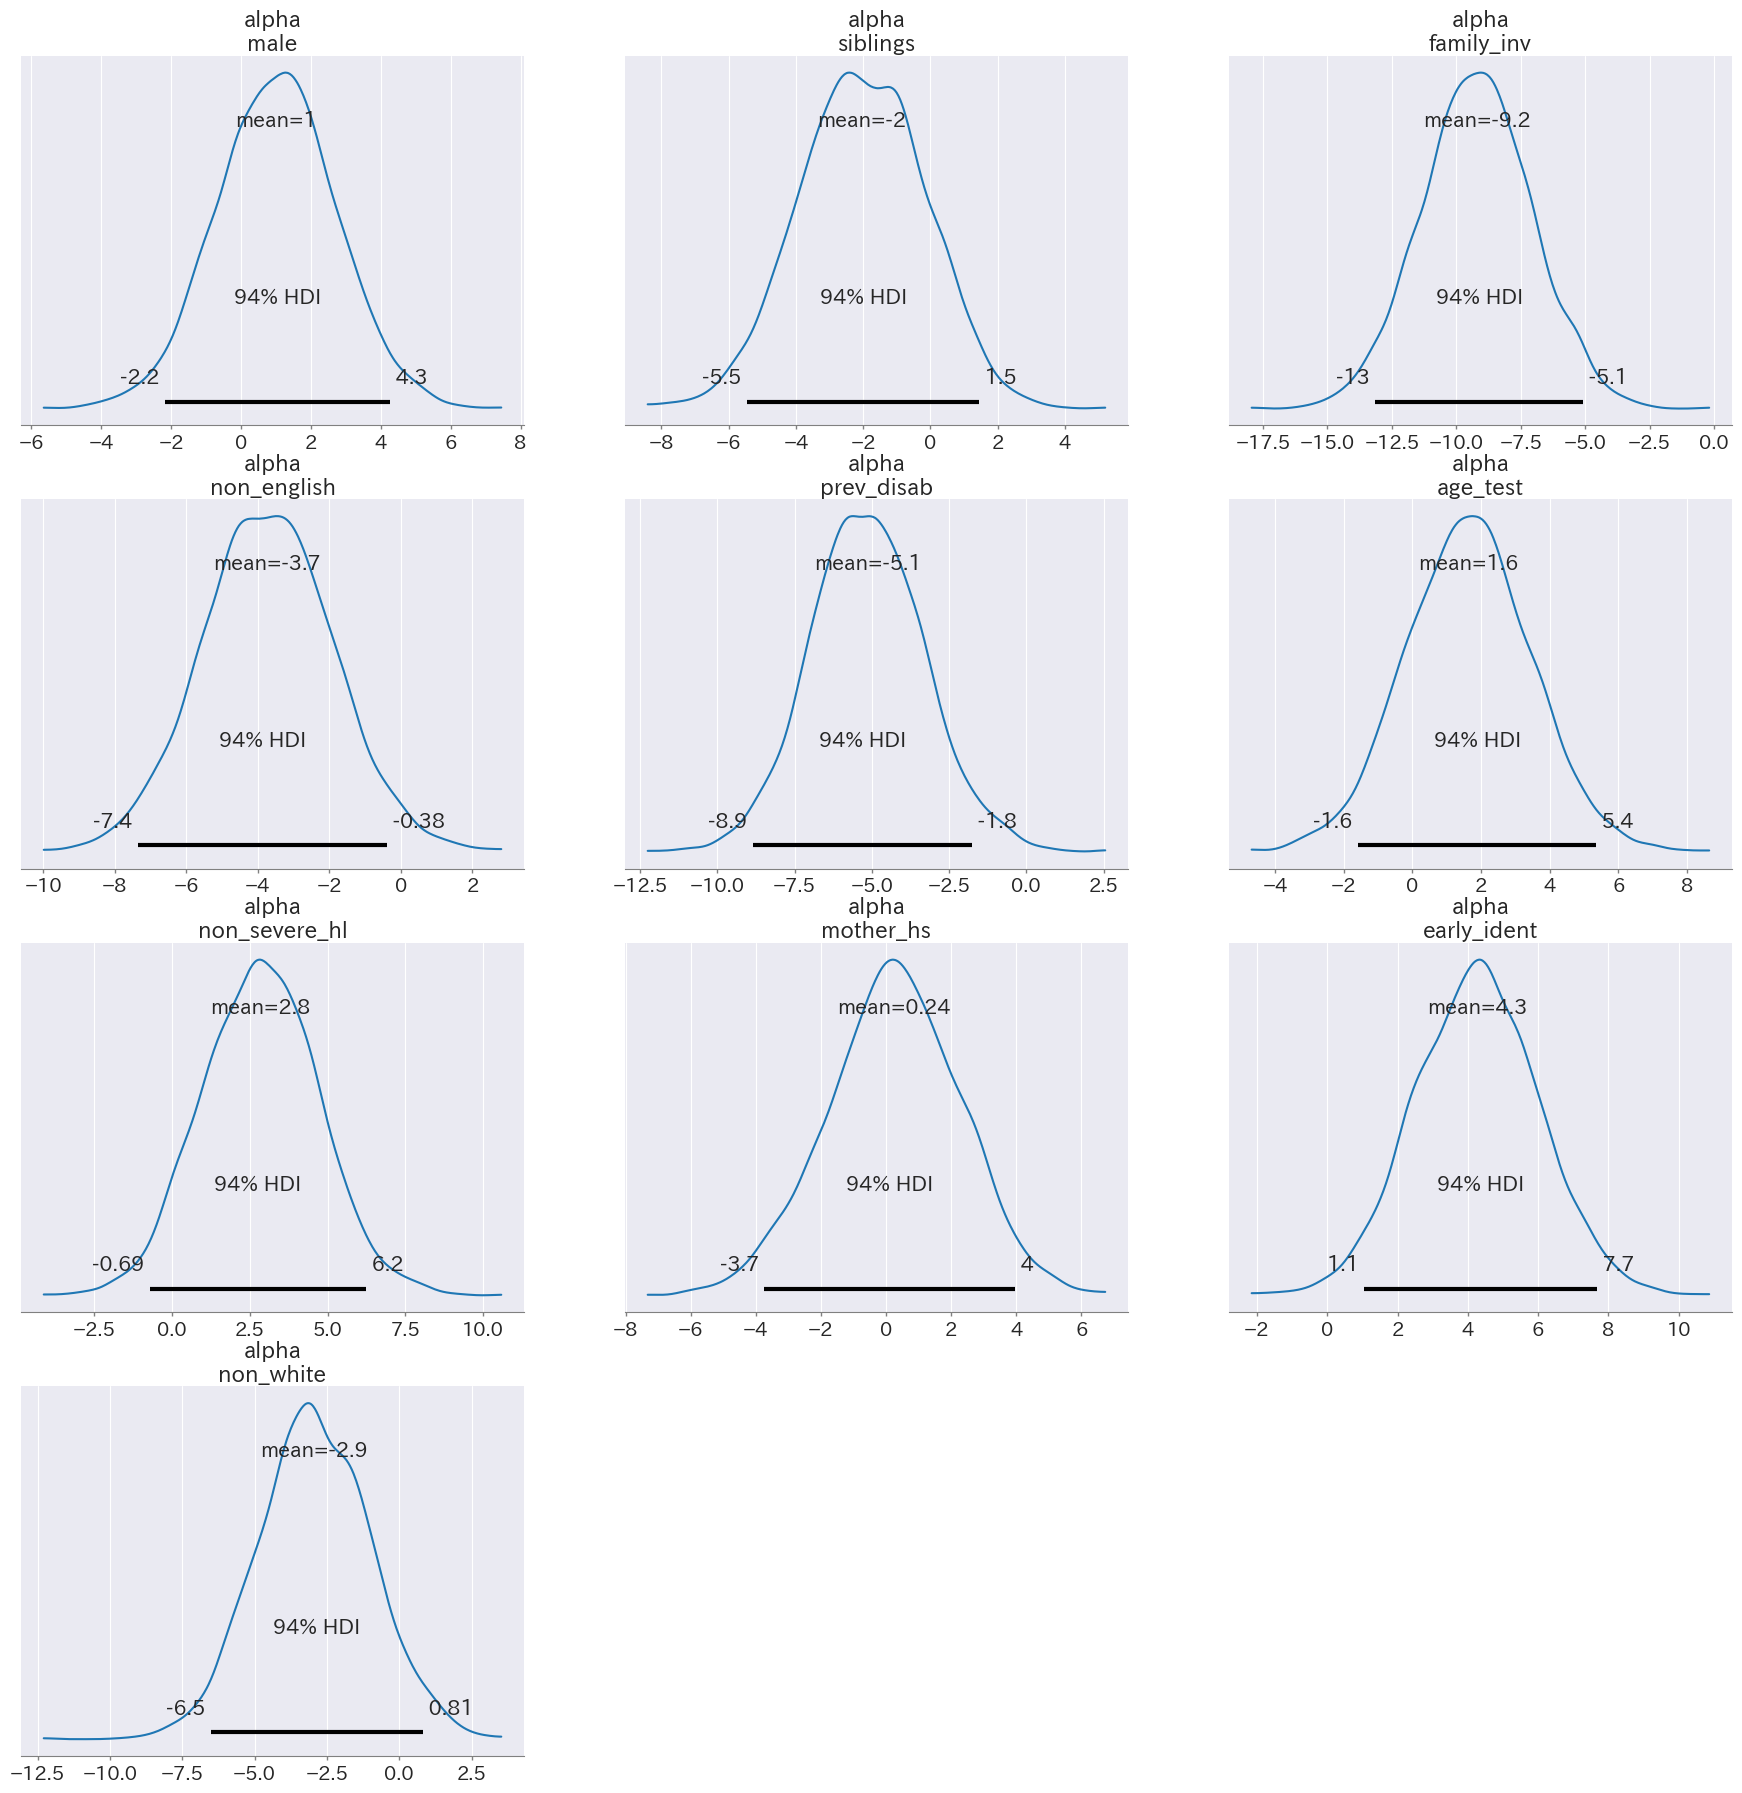

In [22]:
az.plot_posterior(inference_lsl_dr, var_names=['alpha'])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

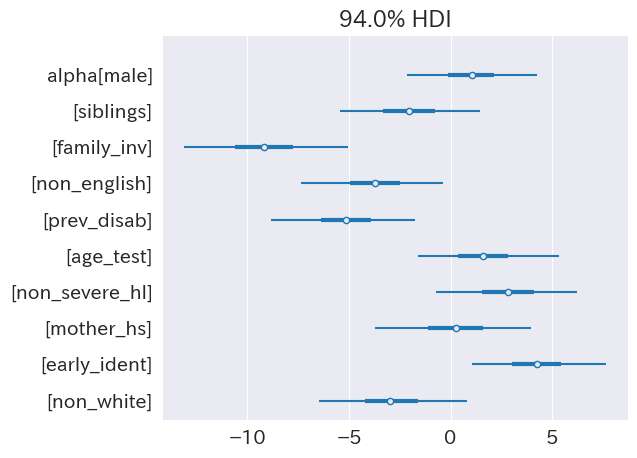

In [21]:
# 各説明変数の寄与度を可視化
az.plot_forest(inference_lsl_dr, var_names=['alpha'], combined=True)  # combined=True で各サンプル直系列をマージして１の集計結果に

 説明変数          | 観点                               | 解約                 
---------------|----------------------------------|--------------------
 male          | 平均値は 0　以上だが 25パーセンタイルは 0 を下回っている | 正の相関があると判断するのは危険   
 siblings      | 平均値 0 以下、hdi97% が 0 以上           | 負の相関があると判断するのはやや危険 
 family_inv    | 平均値, 94% HDI も 0 以下              | 負の相関があると判断できる      
 non_english   | 平均値, 94% HDI も 0 以下              | 負の相関があると判断できる      
 prev_disab    | 平均値, 94% HDI も 0 以下              | 負の相関があると判断できる      
 age_test      | 平均値 0 以上, hdi 3% は 0 以下          | 正の相関があると判断するのはやや危険 
 non_severe_hl | 平均値 0 以上, hdi 3% は 0 以下          | 正の相関があると判断するのはやや危険 
 mother_hs     | 平均値 0 以上, 25%タイル 0以下             | 正の相関があると判断するのは危険   
 early_ident   | 平均値, 94% HDI ともに 0 以上            | 正の相関があると判断できる      
 non_white     | 平均値は 0 以下だが、hdi 97% が 0 以上       | 負の相関があると判断するのはやや危険 
 